###This is a classifier that classifies card color identity based off the text of a card

In [ ]:
from statistics import mean, median
import json
import pandas as pd
import numpy as np
!pip install fastai --upgrade
!pip install fastcore --upgrade
from fastai.text.all import *

##Train generic classifier

In [2]:
df = pd.read_csv('Language_card.csv')

In [3]:
txt_df = df[df['text'].notnull()] 
txt_df.loc[((txt_df['is_colorless']) & (txt_df['is_land'] == False)), 'colorID'] = 'C'
txt_df = txt_df[txt_df['colorID'].notnull()] # Drop any random nans
print(f"Rows dropped: {df.shape[0] - txt_df.shape[0]}")

Rows dropped: 6668


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [4]:
db = DataBlock(blocks=(TextBlock.from_df('text'), CategoryBlock),
               get_x=ColReader('text'),
               get_y=ColReader('colorID'),
               splitter=RandomSplitter(0.2))
dls = db.dataloaders(txt_df)

In [5]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos { 2 } : xxmaj greater xxmaj morphling gains your choice of banding , bushido 1 , double strike , fear , flying , first strike , haste , landwalk of your choice , protection from a color of your choice , provoke , rampage 1 , shadow , or trample until end of turn . \n { 2 } : xxmaj greater xxmaj morphling becomes the colors of your choice until end of turn . \n { 2 } : xxmaj greater xxmaj morphling becomes the creature type of your choice until end of turn . \n { 2 } : xxmaj greater xxmaj morphling 's expansion symbol becomes the symbol of your choice until end of turn . \n { 2 } : xxmaj greater xxmaj morphling 's art becomes by the artist of your choice until end of turn . \n { 2 } : xxmaj",U
1,"xxbos xxmaj fading 7 ( this enchantment enters the battlefield with seven fade counters on it . xxmaj at the beginning of your upkeep , remove a fade counter from it . xxmaj if you ca n't , sacrifice it . ) \n xxmaj remove a fade counter from xxmaj saproling xxmaj burst : xxmaj create a green xxmaj saproling creature token . xxmaj it has "" this creature 's power and toughness are each equal to the number of fade counters on xxmaj saproling xxmaj burst . "" \n xxmaj when xxmaj saproling xxmaj burst leaves the battlefield , destroy all tokens created with xxmaj saproling xxmaj burst . xxmaj they ca n't be regenerated . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",G
2,"xxbos [ +1 ] : xxmaj you gain 2 life . xxmaj add { u } , { r } , or { w } . xxmaj spend this mana only to cast a noncreature spell . \n [ −2 ] : xxmaj draw a card , then you may discard a card . xxmaj when you discard a nonland card this way , xxmaj narset of the xxmaj ancient xxmaj way deals damage equal to that card 's converted mana cost to target creature or planeswalker . \n [ −6 ] : xxmaj you get an emblem with "" whenever you cast a noncreature spell , this emblem deals 2 damage to any target . "" xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","R,U,W"


In [6]:
txt_df['colorID'].value_counts()

G            7814
B            7755
R            7731
W            7589
U            7561
G,W           679
G,R           669
B,U           657
B,R           653
U,W           630
B,G           534
R,U           515
B,W           507
R,W           500
G,U           461
B,R,U         152
G,U,W         116
B,G,R,U,W     116
G,R,W         115
B,G,R         109
B,U,W         101
B,R,W          99
B,G,W          88
B,G,U          84
G,R,U          80
R,U,W          76
G,R,U,W         8
B,G,U,W         7
B,R,U,W         6
B,G,R,W         6
B,G,R,U         2
Name: colorID, dtype: int64

Some of the three color & two color categories are pretty low-N. May be a problem. For now, let's try training a model and seeing how it goes


In [7]:
classifier = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
classifier = classifier.load_encoder('MTG_language_encoder') 
# classifier.lr_find() #3e-3

Train with discriminative learning rates & gradual unfreezing

In [8]:
classifier.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.637322,1.510344,0.544914,00:57


In [9]:
lr_inc = 2.6**4
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(2e-3/lr_inc, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.361624,1.146232,0.691546,00:59


In [10]:
# classifier.lr_find() #(2e-3, e-4) 

In [11]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(2e-3/lr_inc, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.059711,0.837595,0.763650,01:00


In [12]:
classifier.unfreeze()
# classifier.lr_find() #(2e-3, e-4)

In [13]:
classifier.fit_one_cycle(2, slice(2e-3/lr_inc, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.874641,0.702304,0.800969,01:02
1,0.683302,0.600975,0.826948,01:01


In [14]:
# classifier.lr_find() #3e-3

In [15]:
classifier.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.899386,0.769250,0.774218,01:02
1,0.626607,0.551853,0.843131,01:02
2,0.428946,0.409351,0.883091,01:02
3,0.283474,0.381045,0.893549,01:01


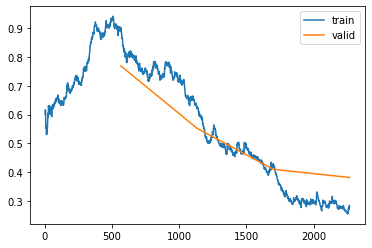

In [16]:
classifier.recorder.plot_loss()

Looks like we can probably get a couple more % higher accuracy but not too crazy about this model thus far. Probably try a multilabel classification instead? With how MTG is setup, this may be a better choice, especially given the low-N of double & tri-colored cards.

Let's see where we're going wrong

In [17]:
interp = ClassificationInterpretation.from_learner(classifier)
interp.most_confused(min_val=15)

[('U', 'W', 60),
 ('G', 'W', 54),
 ('W', 'G', 54),
 ('B', 'W', 34),
 ('U', 'G', 32),
 ('R', 'G', 31),
 ('G', 'R', 28),
 ('R', 'B', 28),
 ('B', 'U', 26),
 ('G,W', 'G', 26),
 ('R', 'W', 26),
 ('W', 'U', 24),
 ('G', 'B', 23),
 ('G', 'U', 21),
 ('W', 'B', 20),
 ('B', 'R', 19),
 ('G,R', 'R', 18),
 ('U', 'B', 18),
 ('B,R', 'R', 17),
 ('U', 'R', 17),
 ('R', 'U', 16),
 ('W', 'R', 16),
 ('B,U', 'B', 15),
 ('B,W', 'B', 15)]

In [18]:
interp.print_classification_report()

              precision    recall  f1-score   support

           B       0.91      0.94      0.92      1567
         B,G       0.90      0.74      0.81        95
       B,G,R       0.95      0.91      0.93        22
     B,G,R,U       0.00      0.00      0.00         0
   B,G,R,U,W       1.00      0.59      0.74        22
     B,G,R,W       1.00      0.67      0.80         3
       B,G,U       0.93      0.87      0.90        15
     B,G,U,W       1.00      1.00      1.00         2
       B,G,W       0.71      0.71      0.71        21
         B,R       0.86      0.77      0.82       137
       B,R,U       0.86      0.60      0.71        30
     B,R,U,W       1.00      1.00      1.00         2
       B,R,W       0.95      0.70      0.81        27
         B,U       0.88      0.76      0.81       133
       B,U,W       0.93      0.74      0.82        19
         B,W       0.96      0.70      0.81        96
           G       0.88      0.91      0.90      1562
         G,R       0.92    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A couples things noteworthy here:
1. The bulk of misclassified data is single-colored. There's likely an effect of single-colored being overrepresented in the dataset as a whole so this isn't too surprising, but I was expected multicolored cards to have greater error prominence
2. As expected, the f1 scores of single colored cards averages around 90% whereas double-colored is around 80% and tricolored varies wildly.

Let's try a multilabel classifier. It's likely this'll be what we want anyways as, despite each color combination having a unique identity & feel, the color combinations are made up of their constituent colors

##Train multilabel classifier

In [19]:
def split_whitespace(c):
    splits = list(c)
    return " ".join(splits)

txt_df['colorID'] = txt_df['colorID'].apply(split_whitespace)

In [20]:
def get_color_labels(r):
    return r['colorID'].split(" ")

db = DataBlock(blocks=(TextBlock.from_df('text'), MultiCategoryBlock),
               get_x=ColReader('text'),
               get_y=get_color_labels,
               splitter=RandomSplitter(0.2))

dls = db.dataloaders(txt_df)

In [21]:
dls.show_batch(max_n=3)

,text,None
0,"xxbos { 2 } : xxmaj greater xxmaj morphling gains your choice of banding , bushido 1 , double strike , fear , flying , first strike , haste , landwalk of your choice , protection from a color of your choice , provoke , rampage 1 , shadow , or trample until end of turn . \n { 2 } : xxmaj greater xxmaj morphling becomes the colors of your choice until end of turn . \n { 2 } : xxmaj greater xxmaj morphling becomes the creature type of your choice until end of turn . \n { 2 } : xxmaj greater xxmaj morphling 's expansion symbol becomes the symbol of your choice until end of turn . \n { 2 } : xxmaj greater xxmaj morphling 's art becomes by the artist of your choice until end of turn . \n { 2 } : xxmaj",U
1,"xxbos xxmaj fading 7 ( this enchantment enters the battlefield with seven fade counters on it . xxmaj at the beginning of your upkeep , remove a fade counter from it . xxmaj if you ca n't , sacrifice it . ) \n xxmaj remove a fade counter from xxmaj saproling xxmaj burst : xxmaj create a green xxmaj saproling creature token . xxmaj it has "" this creature 's power and toughness are each equal to the number of fade counters on xxmaj saproling xxmaj burst . "" \n xxmaj when xxmaj saproling xxmaj burst leaves the battlefield , destroy all tokens created with xxmaj saproling xxmaj burst . xxmaj they ca n't be regenerated . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",G
2,"xxbos xxmaj the xxmaj grand xxmaj xxunk can be your commander . \n xxmaj when xxmaj the xxmaj grand xxmaj xxunk enters the battlefield , each player 's hand becomes a program ( an xxunk row of revealed cards ) . \n xxmaj players can only play the first card of their program . \n xxmaj if a card would be put into a player 's hand from anywhere , that player reveals it and xxunk it anywhere within their program instead . \n xxmaj at the beginning of each player 's end step , if that player 's program has fewer than five cards , they draw cards equal to the difference . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",",;U;W"


In [25]:
multiclass = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy_multi).to_fp16()
multiclass = multiclass.load_encoder('MTG_language_encoder') 
# multiclass.lr_find() #3e-3

In [26]:
multiclass.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.464979,0.360466,0.854910,01:06


In [27]:
multiclass.freeze_to(-2)
# multiclass.lr_find() # 1e-3

In [28]:
multiclass.fit_one_cycle(2, slice(1e-3/lr_inc, 1e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.402394,0.315906,0.870358,01:07
1,0.365035,0.290161,0.882706,01:06


In [29]:
multiclass.freeze_to(-4)
# multiclass.lr_find() # 4e-2 should be fine

In [30]:
multiclass.fit_one_cycle(2, slice(4e-2/lr_inc, 4e-2))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.257432,0.221823,0.914795,01:10
1,0.179739,0.148567,0.945784,01:09


94% accuracy before final unfreezing, pretty good!


In [31]:
multiclass.unfreeze()
# multiclass.lr_find() # 2e-5 to 2e-3

In [32]:
multiclass.fit_one_cycle(3, lr_max=slice(2e-5, 2e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.142516,0.141466,0.948701,01:10
1,0.141507,0.134840,0.951600,01:09
2,0.133344,0.134317,0.951985,01:08


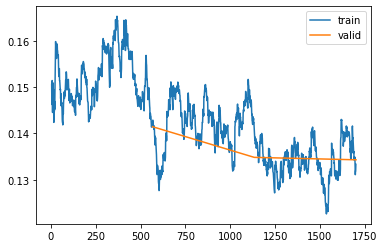

In [33]:
multiclass.recorder.plot_loss()

Able to squeeze out an extra % or so from training the unfrozen model. Overall pretty happy with this barebones model performance!

In [34]:
multiclass.save('MTG_text-to-color_multilabel_classifier')

Path('models/MTG_text-to-color_multilabel_classifier.pth')